In [ ]:
# https://drive.google.com/file/d/16MW3BRcWXMR8mx4d8yhJ3af_CWVoBmQZ/view?usp=sharing

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install nltk

# Prática — Módulo 1: Introdução ao Processamento de Linguagem Natural


## Prática
O objetivo desta prática é fazer o aluno percorrer o início do pipeline de PLN a partir de textos reais: leitura do corpus, exploração básica, tokenização com NLTK e efeitos de um pré-processamento mínimo sobre o vocabulário e as estatísticas do texto — sem treinar modelos.

## Dataset
O arquivo imdb_dataset.csv contém resenhas de filmes traduzidas para o português, acompanhadas de uma nota numérica atribuída pelo usuário. Cada linha corresponde a uma resenha independente. O corpus é textual, ruidoso e heterogêneo, adequado para ilustrar desafios típicos de PLN (ambiguidade, informalidade, pontuação irregular e variação lexical).


In [9]:
import pandas as pd

df = pd.read_csv(
    "IMDB-Dataset.csv",
    engine="python",          # Parser mais tolerante.
    on_bad_lines="skip"       # Pula linhas problemáticas.
)

### Pergunta
0. Escolha cinco palavras distintas (por exemplo: {casa, carro, filme, bom, ruim}), defina um vocabulário ordenado e construa manualmente a representação one-hot de cada palavra. Explique por que o número de dimensões é igual ao tamanho do vocabulário.

In [47]:
# Exemplo de one-hot (independente do corpus).
vocab = ["casa", "carro", "filme", "bom", "ruim"]
index = {w: i for i, w in enumerate(vocab)}

def one_hot(word, vocab_index):
    vec = [0] * len(vocab_index)
    vec[vocab_index[word]] = 1
    return vec

print("Vocabulário:", index)
for w in vocab:
    print(w, "→", one_hot(w, index))


Vocabulário: {'casa': 0, 'carro': 1, 'filme': 2, 'bom': 3, 'ruim': 4}
casa → [1, 0, 0, 0, 0]
carro → [0, 1, 0, 0, 0]
filme → [0, 0, 1, 0, 0]
bom → [0, 0, 0, 1, 0]
ruim → [0, 0, 0, 0, 1]


### Pergunta
1.	Carregue o CSV em Python, identifique qual coluna contém as resenhas em português e, a partir de df.shape, df.head() e df.info(), descreva que tipo de corpus você tem (domínio, unidade de análise e natureza do material textual) e por que isso configura um problema típico de PLN. Reduza o dataset a 10000 amostras por rating.

In [31]:
# EDA mínimo para corpus textual.
print("=== Dimensão do corpus ===")
print(df.shape, "\n")

print("=== Primeiras 10 linhas ===")
print(df.head(10), "\n")

print("=== Estrutura do dataset ===")
print(df.info(), "\n")

print("=== Estatísticas básicas do texto ===")
print({
    "n_documentos": len(df),
    "media_caracteres": df["Resenhas"].astype(str).str.len().mean(),
    "media_palavras": df["Resenhas"].astype(str).str.split().str.len().mean(),
    "textos_nulos": df["Resenhas"].isna().sum(),
    "textos_vazios": (df["Resenhas"].astype(str).str.strip() == "").sum()
})

=== Dimensão do corpus ===
(149573, 4) 

=== Primeiras 10 linhas ===
   Ratings                                            Reviews  \
0      1.0  *Disclaimer: I only watched this movie as a co...   
1      1.0  I am writing this in hopes that this gets put ...   
2      1.0  Really, I could write a scathing review of thi...   
3      1.0  If you saw the other previous spoof movies by ...   
4      1.0  This movie I saw a day early for free and I st...   
5      1.0  Honestly, what is wrong with you, Hollywood? N...   
6      1.0  I was given a free ticket to this film; so I c...   
7      1.0  OK, so "Disastrous" isn't an imaginative barb ...   
8      1.0  Jason Friedberg and Aaron Seltzer, the way eve...   
9      1.0  Honestly the worst movie ever made. Theatre fu...   

                           Movies  \
0                  Disaster Movie   
1                  Disaster Movie   
2                  Disaster Movie   
3                  Disaster Movie   
4                  Disaster Mo

In [32]:
# Manter apenas a coluna em português ()
df = df.drop(columns=["Reviews", "Movies"])

# Mudar o nome para algo canônico (gosto de usar texto :)
df = df.rename(columns={"Resenhas": "texto"})

df.columns.to_list()


['Ratings', 'texto']

In [33]:
# Reduzir o dataset para 10.000 registros por rating (amostragem estratificada).
df_reduzido = (
    df
    .groupby("Ratings")
    .sample(n=1000, random_state=42)
    .reset_index(drop=True)
)

df_reduzido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ratings  10000 non-null  float64
 1   texto    10000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


### Pergunta
2.	Escolha três resenhas de tamanhos diferentes e, apenas lendo o texto, aponte três características da linguagem natural (ex.: ambiguidade, ironia, informalidade, erros, gírias, pontuação expressiva) que dificultariam uma análise automática direta.

In [34]:
# Selecionar três exemplos de text: curto, médio e longo.
df_reduzido["tamanho"] = df_reduzido["texto"].astype(str).str.len()

curto = df_reduzido.loc[df_reduzido["tamanho"].idxmin(), "texto"]
medio = df_reduzido.loc[df_reduzido["tamanho"].sort_values().index[len(df_reduzido)//2], "texto"]
longo = df_reduzido.loc[df_reduzido["tamanho"].idxmax(), "texto"]

print("--- Curto ---\n", curto, "\n")
print("--- Médio ---\n", medio[:500], "...\n")
print("--- Longo ---\n", longo[:500], "...\n")



--- Curto ---
 Nem merece uma revisão, evite a todo custo. 

--- Médio ---
 Se você gostou do original (o que eu fiz) e espera o mesmo nível de "sofisticação" aqui, não. Esta não é a sequência que você estava esperando. "Porky's II: The Next Day" oferece algumas risadas, mas o resto é preenchido com subtramas sobre o KKK, campanhas políticas, índios americanos e religião de direita. Isso em um filme com um personagem chamado Pee-Wee? Talvez Bob Clark sentisse que precisava fazer alguma expiação social pelas coisas que não eram do PC que ele cometeu no original. Sem Pork ...

--- Longo ---
 Fallout parece uma sequência direta de Rogue Nation, mesmo que não ocorra imediatamente depois na linha do tempo (com base em algum diálogo que acredito que seja dois anos depois). Mas muitas coisas permaneceram consistentes: finalmente mantivemos um diretor (eu falarei disso mais tarde) e muitos dos personagens retornaram, incluindo um Solomon Lane (interpretado por Sean Harris) com mais vilania do 

### Pergunta
3.	Compare a coluna Ratings com a coluna de texto: mostre com exemplos no Jupyter por que operações numéricas (média, histograma, correlação) fazem sentido para Ratings, mas não fazem sentido diretamente sobre o texto — e o que isso implica para análise de dados estruturados vs. linguagem natural.

In [35]:
import matplotlib.pyplot as plt


Média de Ratings: 5.5


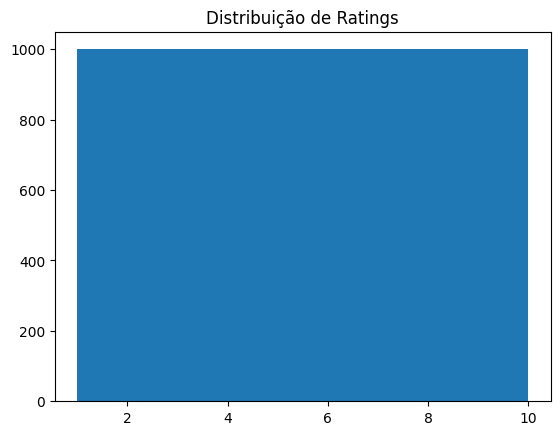

In [36]:
# Visualizar médias em um histograma.
print("Média de Ratings:", df_reduzido["Ratings"].mean())

plt.hist(df_reduzido["Ratings"], bins=10)
plt.title("Distribuição de Ratings")
plt.show()


Média de caracteres: 1262.9671


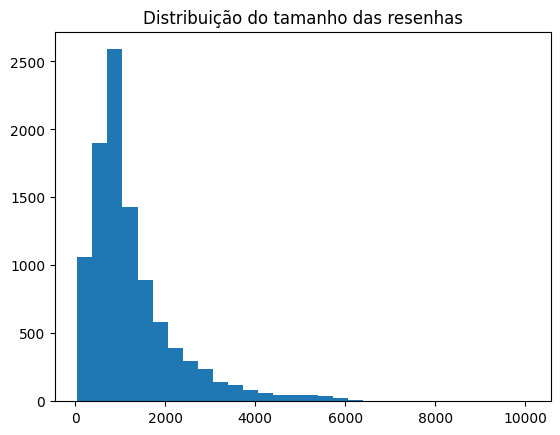

In [37]:
# Visualizar contagem de caracteres em um histograma.
df_reduzido["tamanho"] = df_reduzido["texto"].astype(str).str.len()

print("Média de caracteres:", df_reduzido["tamanho"].mean())

plt.hist(df_reduzido["tamanho"], bins=30)
plt.title("Distribuição do tamanho das resenhas")
plt.show()


In [38]:
df_reduzido["Ratings"].describe()

,Ratings
count,10000.000000
mean,5.500000
std,2.872425
min,1.000000
25%,3.000000
50%,5.500000
75%,8.000000
max,10.000000


### Pergunta
4.	Em uma única resenha, aplique um pré-processamento mínimo (lowercase e remoção básica de pontuação) e mostre explicitamente o “antes vs. depois”, explicando o que mudou e por que isso é uma etapa típica do pipeline de PLN.

In [39]:
# Aplicar lowercase + remoção de pontuação em uma resenha.
import re

# Escolher uma resenha de exemplo.
exemplo = df_reduzido["texto"].iloc[0]

# Pré-processamento mínimo.
antes = exemplo
depois = re.sub(r"[^\w\s]", "", exemplo.lower())

print("=== ANTES ===\n", antes[:500], "\n")
print("=== DEPOIS ===\n", depois[:500])


=== ANTES ===
 Lixo completo. O episódio "chifre, chifre doce" não passa de transfobia velada! é 2016! Isso foi feito em 2016 !!!! Deveríamos ter passado disso! não apenas isso, mas os outros episódios são fracos e um insulto completo ao programa antigo. Acho esse programa incrivelmente decepcionante e não o recomendaria a ninguém. E eu especialmente não gostaria que as crianças o vissem com transfobia tão flagrante, e se uma das crianças assistindo é trans e se sente péssima consigo mesma por causa da sua pre 

=== DEPOIS ===
 lixo completo o episódio chifre chifre doce não passa de transfobia velada é 2016 isso foi feito em 2016  deveríamos ter passado disso não apenas isso mas os outros episódios são fracos e um insulto completo ao programa antigo acho esse programa incrivelmente decepcionante e não o recomendaria a ninguém e eu especialmente não gostaria que as crianças o vissem com transfobia tão flagrante e se uma das crianças assistindo é trans e se sente péssima consigo mesma p

### Pergunta
5.	Use o NLTK para tokenizar essa mesma resenha por palavras e reporte: (a) número de tokens gerados e (b) dois exemplos de tokens que não correspondem a “palavras visuais” (ex.: sinais, contrações ou fragmentos).

In [40]:
# Baixar recursos necessários e tokenizar a resenha com NLTK.

import nltk
from nltk.tokenize import word_tokenize

# Baixar recursos de tokenização (executar apenas uma vez no ambiente).
nltk.download("punkt")
nltk.download("punkt_tab")

# Usar a mesma resenha já pré-processada na Q4.
texto_q4 = depois

# Tokenização por palavras.
tokens = word_tokenize(texto_q4, language="portuguese")

print("Número de tokens:", len(tokens))
print("\nPrimeiros 20 tokens:\n", tokens[:20])


[nltk_data] Downloading package punkt to /root/nltk_data...


Número de tokens: 117

Primeiros 20 tokens:
 ['lixo', 'completo', 'o', 'episódio', 'chifre', 'chifre', 'doce', 'não', 'passa', 'de', 'transfobia', 'velada', 'é', '2016', 'isso', 'foi', 'feito', 'em', '2016', 'deveríamos']


[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Pergunta
6.	Generalizando o que foi feito na Q4, aplique lowercase e remoção de pontuação em todo o corpus, calcule o tamanho do vocabulário antes e depois e interprete por que o vocabulário diminui — relacionando isso à etapa de pré-processamento do pipeline.

In [41]:
# Aplicar lowercase + remoção de pontuação em todo o corpus.
import re   # Biblioteca do Python para expressões regulares (regular expressions)
from nltk.tokenize import word_tokenize

# Concatenar todo o corpus uma única vez (evita loop Python)
texto_todo = " ".join(df_reduzido["texto"].astype(str).values)

# Vocabulário antes
tokens_antes = word_tokenize(texto_todo, language="portuguese")
vocab_antes = set(tokens_antes)

# Limpeza vetorizada
df_reduzido["texto_limpo"] = (
    df_reduzido["texto"]
    .astype(str)
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)
)

# Concatenar novamente após limpeza
texto_todo_limpo = " ".join(df_reduzido["texto_limpo"].values)

# Vocabulário depois
tokens_depois = word_tokenize(texto_todo_limpo, language="portuguese")
vocab_depois = set(tokens_depois)

print("Tamanho do vocabulário ANTES:", len(vocab_antes))
print("Tamanho do vocabulário DEPOIS:", len(vocab_depois))
print("Redução absoluta:", len(vocab_antes) - len(vocab_depois))

Tamanho do vocabulário ANTES: 75302
Tamanho do vocabulário DEPOIS: 63838
Redução absoluta: 11464


### Pergunta
7.	Sem usar nenhum modelo de ML, calcule as 10 palavras mais frequentes (após limpeza mínima) e justifique por que esses termos tendem a aparecer mais (função gramatical vs. conteúdo semântico).

In [42]:
# Calcular as 10 palavras mais frequentes (usa tokens_depois gerados na Q6)
from collections import Counter

tokens = tokens_depois  # <-- vem diretamente da Q6

freq = Counter(tokens)
top10 = freq.most_common(10)
top10

[('de', 84898),
 ('que', 65680),
 ('e', 65130),
 ('o', 59798),
 ('a', 48570),
 ('é', 43862),
 ('um', 42900),
 ('filme', 34510),
 ('não', 31355),
 ('uma', 26812)]

### Pergunta
8.	Recalcule as 10 palavras mais frequentes removendo stopwords do NLTK (português).
Compare com o resultado da Q7 e explique tecnicamente por que o ranking mudou.

In [43]:
# Calcular as 10 palavras mais frequentes após remoção de stopwords.
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from collections import Counter

stop_pt = set(stopwords.words('portuguese'))

tokens_sem_sw = [t for t in tokens_depois if t not in stop_pt]
top10_sem_sw = Counter(tokens_sem_sw).most_common(10)

top10_sem_sw

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('filme', 34510),
 ('filmes', 7128),
 ('realmente', 5967),
 ('história', 5558),
 ('tão', 5067),
 ('apenas', 4995),
 ('sobre', 4438),
 ('bem', 4357),
 ('pode', 4264),
 ('bom', 4116)]

### Pergunta
9.	Em que tipos de tarefas de PLN a remoção de stopwords tende a ser útil, e em quais ela pode ser prejudicial? Justifique tecnicamente.

### Pergunta
10.	Crie uma representação Bag-of-Words simples com NLTK (contagem de tokens por documento) para 5 resenhas escolhidas. Reporte o formato do resultado e explique por que ele já é uma forma de “representação numérica” do texto.

In [44]:
# Criar Bag-of-Words simples para 5 resenhas.
from collections import Counter
from nltk.tokenize import word_tokenize

# Selecionar 5 resenhas.
amostra = df_reduzido["texto_limpo"].dropna().iloc[:5]

bow = []
for texto in amostra:
    tokens = word_tokenize(texto, language="portuguese")
    bow.append(Counter(tokens))

bow


[Counter({'lixo': 1,
          'completo': 2,
          'o': 3,
          'episódio': 2,
          'chifre': 2,
          'doce': 1,
          'não': 4,
          'passa': 1,
          'de': 3,
          'transfobia': 2,
          'velada': 1,
          'é': 3,
          '2016': 2,
          'isso': 3,
          'foi': 1,
          'feito': 1,
          'em': 1,
          'deveríamos': 1,
          'ter': 1,
          'passado': 1,
          'disso': 1,
          'apenas': 1,
          'mas': 1,
          'os': 1,
          'outros': 1,
          'episódios': 1,
          'são': 1,
          'fracos': 1,
          'e': 6,
          'um': 2,
          'insulto': 1,
          'ao': 1,
          'programa': 2,
          'antigo': 1,
          'acho': 1,
          'esse': 1,
          'incrivelmente': 1,
          'decepcionante': 1,
          'recomendaria': 1,
          'a': 3,
          'ninguém': 1,
          'eu': 2,
          'especialmente': 1,
          'gostaria': 1,
          'qu

### Pergunta
11.	A partir desse mesmo corpus, explique concretamente como ele poderia ser usado para quatro problemas clássicos de PLN — indicando o “produto” em cada caso e, quando aplicável, como os rótulos poderiam ser obtidos a partir dos dados existentes: (a) classificação de textos, (b) análise de sentimento, (c) extração de informação, (d) modelagem de tópicos.

**ATENÇÃO**

Você deve salvar o dataset já limpo em CSV no estado atual, pois ele é entrada para o Módulo 5.

In [45]:
# Salva o dataset já limpo para ser utilizado no Módulo 2
df_reduzido.to_csv("/content/IMDB-Dataset-Reduzido.csv", index=False)